# California Timeseries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#import pmdarima as pm

### Loading data

In [2]:
df_emp=pd.read_pickle("emp_dfpkl.sec")

In [3]:
df_emp= df_emp[['Michigan','California','Ohio','Texas','Indiana']]

In [4]:
emp_final= df_emp[238:]

#### Indiana Dataset

In [8]:
california=emp_final['California']

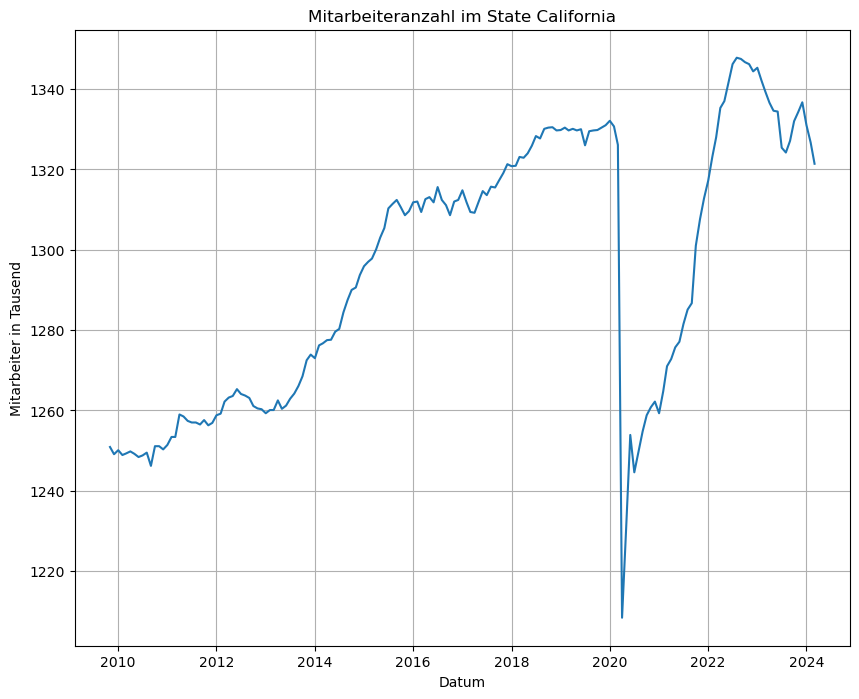

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(california)
plt.title('Mitarbeiteranzahl im State California')
plt.xlabel('Datum')
plt.ylabel('Mitarbeiter in Tausend')
plt.grid(True)
plt.show()

### Test und Trainingsdaten

In [15]:
#Test und Traingsdaten
train = california[:int(0.9 * len(california))]
test = california[int(0.9 * len(california)):]

In [16]:
pred_start= test.index[0]
pred_end= test.index[-1]

In [17]:
print(f"Länge des Trainingsdatensatzes: {len(train)}")
print(f"Länge des Testdatensatzes: {len(test)}")

Länge des Trainingsdatensatzes: 155
Länge des Testdatensatzes: 18


# Samira

### Besteht aus ARIMA (AR -> Autoregression, I -> Differenzierung und MA-> Gleitender Durschschnitt) plus Saisonale Komponenten S auf ARIMA 

## 1. Stationary

In [18]:
result = adfuller(california)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -2.0946170447740404
p-value: 0.24668461677643805


keine stationarity

In [19]:
california_diff= california.diff().dropna()

In [20]:
result = adfuller(california_diff)
print(f'ADF Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Test Statistic: -11.022300968345622
p-value: 5.945580764417625e-20


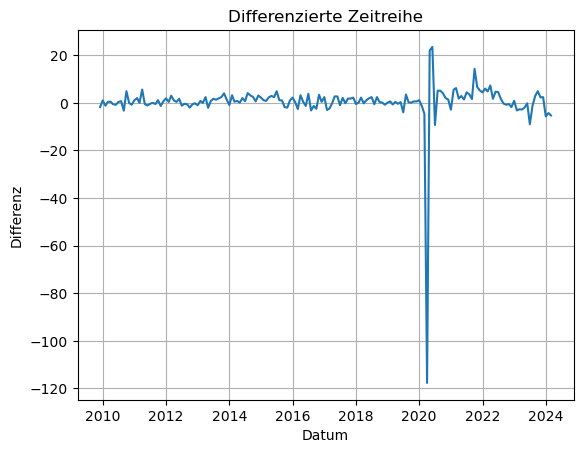

In [21]:
plt.plot(california_diff)
plt.title('Differenzierte Zeitreihe')
plt.xlabel('Datum')
plt.ylabel('Differenz')
plt.grid(True)
plt.show()

## 2. PACF und ACF

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

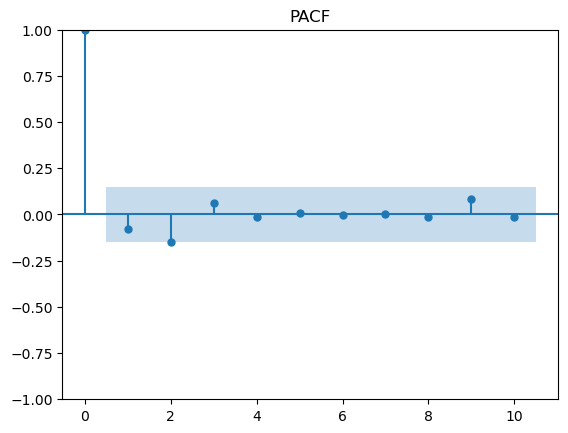

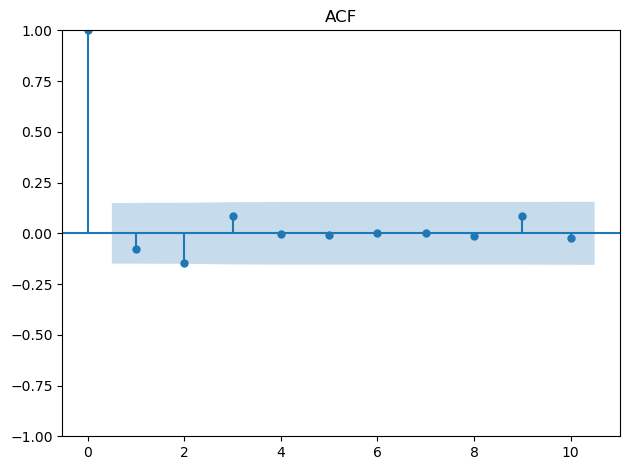

In [25]:
plot_pacf(california_diff,lags=10,title='PACF')
plot_acf(california_diff,lags=10,title='ACF')
plt.tight_layout()
plt.show()

### Gleitender Durchschnitt mit rolling window

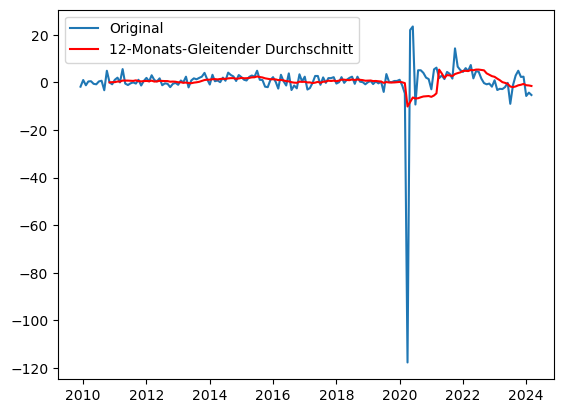

In [27]:
MA = california_diff.rolling(window=12).mean()
plt.plot(california_diff, label='Original')
plt.plot(MA, label='12-Monats-Gleitender Durchschnitt', color='red')
plt.legend()
plt.show()

### Gleitender durschnitt mit ARIMA

In [28]:
from statsmodels.tsa.arima.model import ARIMA

In [29]:
#MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung
MA_modell= ARIMA(train,order=(0,0,2)) # -> nur MA berechnung

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [30]:
MA_fit= MA_modell.fit()
print(MA_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             California   No. Observations:                  155
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -644.608
Date:                Sat, 05 Oct 2024   AIC                           1297.215
Time:                        23:33:14   BIC                           1309.389
Sample:                    11-01-2009   HQIC                          1302.160
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1290.0284      3.817    337.978      0.000    1282.547    1297.509
ma.L1          1.1266      0.037     30.784      0.000       1.055       1.198
ma.L2          0.5551      0.045     12.463      0.0

P > Z sagt aus welche Lags signifikant sind. alles unter 0.05 sind nicht signifikant

In [31]:
ma_pred=MA_fit.predict(start=pred_start, end= pred_end)
residuals=test-ma_pred

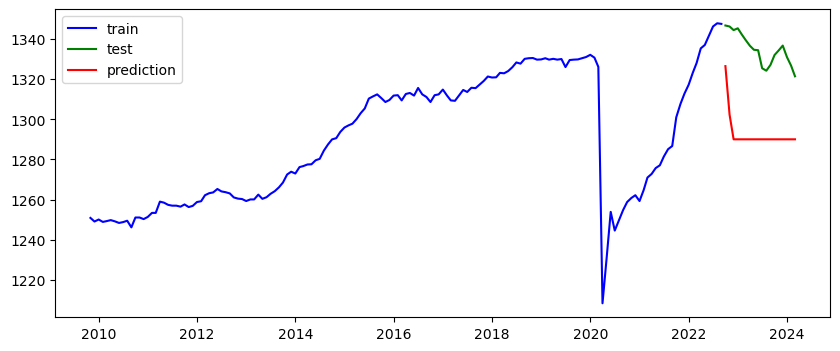

In [32]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ma_pred, label='prediction',color='red')
plt.legend()
plt.show()

# AR -> Autoregression 

In [33]:
ar_modell= ARIMA(train,order=(2,0,0))
ar_fit=ar_modell.fit()
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             California   No. Observations:                  155
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -579.749
Date:                Sat, 05 Oct 2024   AIC                           1167.498
Time:                        23:33:41   BIC                           1179.672
Sample:                    11-01-2009   HQIC                          1172.443
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1292.1976     28.443     45.431      0.000    1236.451    1347.944
ar.L1          0.9015      0.079     11.400      0.000       0.747       1.057
ar.L2          0.0568      0.071      0.800      0.4

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Prediction with Ar models

In [34]:
ar_pred=ar_fit.predict(start=pred_start, end= pred_end)
residuals=test-ar_pred

Ploting

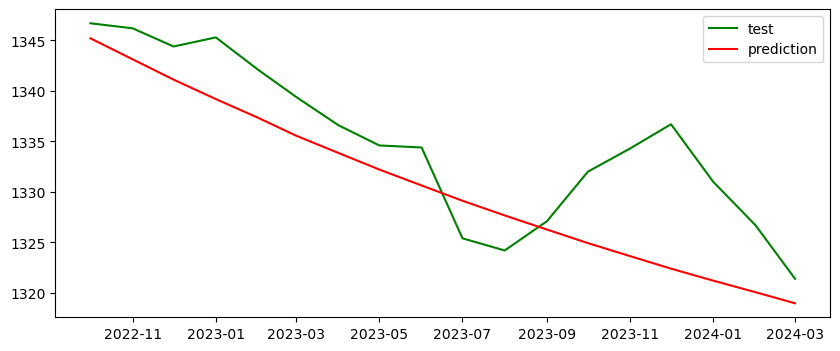

In [35]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( ar_pred, label='prediction',color='red')
plt.legend()
plt.show()

### Evaulation

In [36]:
test_mae = mean_absolute_error(test, ar_pred)
test_mse = mean_squared_error(test, ar_pred)
test_rmse = mean_squared_error(test, ar_pred, squared=False)
test_r2 = r2_score(test, ar_pred)

In [37]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 5.019267389740043
mse 36.94240602370995
rmse 6.07802649086938
r2 0.3859676083025634


# Arima (p,d,q)

In [44]:
arima_modell= ARIMA(train, order=(2,1,2)) #best order 3,0,1
arima_fit=arima_modell.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             California   No. Observations:                  155
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -573.863
Date:                Sat, 05 Oct 2024   AIC                           1157.726
Time:                        23:34:21   BIC                           1172.911
Sample:                    11-01-2009   HQIC                          1163.894
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4806      1.151     -0.418      0.676      -2.736       1.775
ar.L2         -0.2097      1.110     -0.189      0.850      -2.386       1.967
ma.L1          0.3984      1.151      0.346      0.7

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
arima_pred=arima_fit.predict(start=pred_start, end= pred_end)
residuals=test-arima_pred

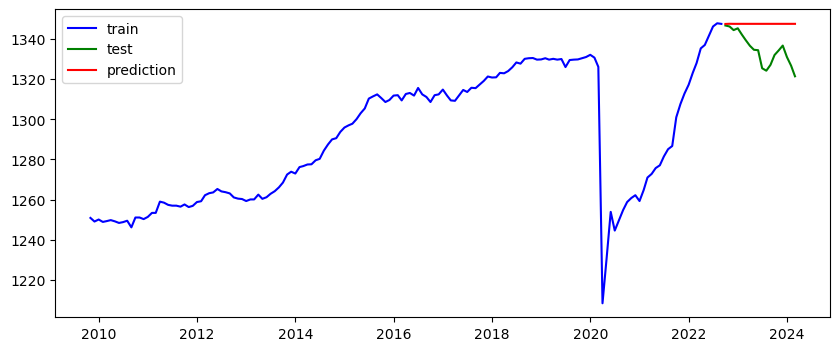

In [47]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( arima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [48]:
test_mae = mean_absolute_error(test, arima_pred)
test_mse = mean_squared_error(test, arima_pred)
test_rmse = mean_squared_error(test, arima_pred, squared=False)
test_r2 = r2_score(test, arima_pred)

In [49]:
print('mae',test_mae)
print('mse',test_mse)
print('rmse',test_rmse)
print('r2',test_r2)

mae 12.601918838995289
mse 219.0123740412672
rmse 14.799066661153574
r2 -2.6402797304967645


# Sarima (p,d,q)(P,D,Q)s

In [50]:
my_order = (2,1,2)
my_sorder = (1,1,1,12)

In [51]:
sarima_modell = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
sarima_fit=sarima_modell.fit()
print(sarima_fit.summary())

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           California   No. Observations:                  155
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -545.639
Date:                              Sat, 05 Oct 2024   AIC                           1105.279
Time:                                      23:35:02   BIC                           1125.969
Sample:                                  11-01-2009   HQIC                          1113.686
                                       - 09-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4791      1.427     -0.336      0.737      -3.276       2.317
ar.L2         -0.26

In [91]:
sarima_pred=sarima_fit.predict(start=pred_start, end= pred_end)
residuals=test-sarima_pred

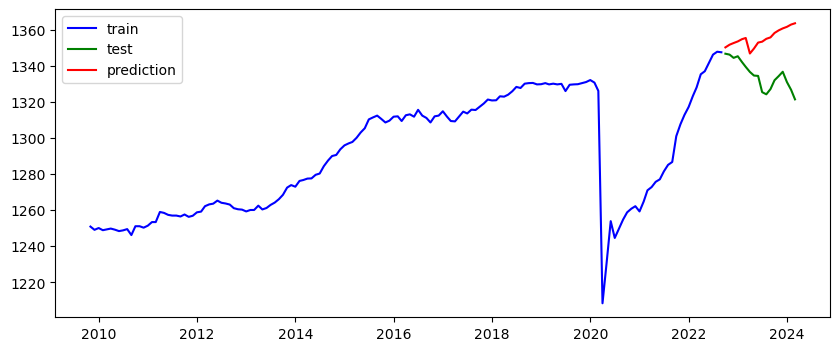

In [92]:
plt.figure(figsize=(10,4))
plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [93]:
test_mae = mean_absolute_error(test, sarima_pred)
test_mse = mean_squared_error(test, sarima_pred)
test_rmse = mean_squared_error(test, sarima_pred, squared=False)
test_r2 = r2_score(test, sarima_pred)

In [94]:
print('mae',test_mae)
print('mse',test_mse)
print('MSE', round(np.mean(abs(residuals/test)),4))
print('rmse',test_rmse)
print('r2',test_r2)

mae 20.53314763559115
mse 541.088305521995
MSE 0.0154
rmse 23.261304897232122
r2 -7.993614171907097


# Auto Sarima

In [58]:
import pmdarima as pm

In [72]:
auto_sarima = pm.auto_arima(train,d=None, stationary= False,
                           m=12, start_p=0, max_p=11, max_d= 1,approximation = True, start_q=0, max_q=11, start_P=0, D=None, start_Q=0, max_P=11, max_D=1, max_Q=11, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1156.492, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1159.364, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1158.906, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1155.072, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1158.490, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1158.490, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1160.321, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1157.364, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1156.906, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1157.885, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.583 seconds


In [77]:
my_order = (0,1,0)
my_sorder = (0,0,0,12)

In [78]:
a_sarima = SARIMAX(train, order=my_order, seasonal_order=my_sorder)
auto_s_fit = a_sarima.fit()
print(auto_s_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             California   No. Observations:                  155
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -576.536
Date:                Sat, 05 Oct 2024   AIC                           1155.072
Time:                        23:38:04   BIC                           1158.109
Sample:                    11-01-2009   HQIC                          1156.306
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       104.5544      1.583     66.063      0.000     101.452     107.656
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):             86935.97
Prob(Q):                              0.28   Pr

C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Anwender\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [89]:
auto_sarima_pred=auto_s_fit.predict(start=pred_start, end= pred_end)
residuals=test-auto_sarima_pred

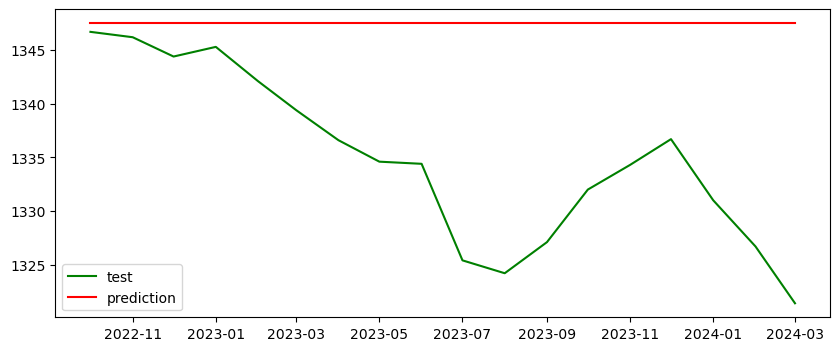

In [90]:
plt.figure(figsize=(10,4))
#plt.plot(train, label='train',color= 'blue')
plt.plot(test, label='test',color='green')
plt.plot( auto_sarima_pred, label='prediction',color='red')
plt.legend()
plt.show()

# Evaulation

In [87]:
test_mae = mean_absolute_error(test, auto_sarima_pred)
test_mse = mean_squared_error(test, auto_sarima_pred)
test_rmse = mean_squared_error(test, auto_sarima_pred, squared=False)
test_r2 = r2_score(test, auto_sarima_pred)

In [88]:
print('mae',test_mae)
print('mse',test_mse)
print('MSE', round(np.mean(abs(residuals/test)),4))
print('rmse',test_rmse)
print('r2',test_r2)

mae 12.583333333333321
mse 218.5038888888884
MSE 0.0095
rmse 14.781877042138065
r2 -2.6318280245072465
